# Method 3 - Best Ideas DGTW Selection

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)


monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

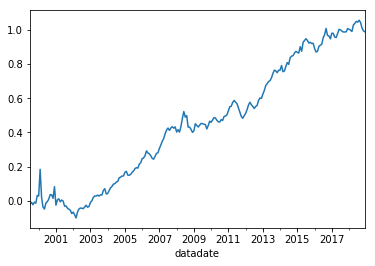

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.031692
2000-12-31    0.048943
2001-12-31   -0.145069
2002-12-31    0.044732
2003-12-31    0.076050
2004-12-31    0.101054
2005-12-31    0.067565
2006-12-31    0.047853
2007-12-31    0.118209
2008-12-31   -0.022471
2009-12-31    0.046859
2010-12-31    0.024800
2011-12-31   -0.002913
2012-12-31    0.067507
2013-12-31    0.103192
2014-12-31    0.062574
2015-12-31    0.025487
2016-12-31    0.013303
2017-12-31    0.030899
2018-12-31   -0.009391
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     16.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.46e-12
Time:                        12:46:23   Log-Likelihood:                 607.68
No. Observations:                 234   AIC:                            -1205.
Df Residuals:                     229   BIC:                            -1188.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.565      0.119      -0.001       0.004
mktrf         -0.0009      0.034     -0.026      0.979      -0.068       0.066
me             0.3097      0.040      7.833      0.000       0.232       0.388
ia            -0.1115      0.060     -1.856      0.065      -0.230       0.007
roe            0.0629      0.051      1.223      0.223      -0.038       0.164
==============================================================================
Omnibus:                      104.671   Durbin-Watson:                   2.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1109.768
Skew:                          -1.439   Prob(JB):                    1.04e-241
Kurtosis:                      13.273   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     3.474
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00888
Time:                        12:46:23   Log-Likelihood:                 607.68
No. Observations:                 234   AIC:                            -1205.
Df Residuals:                     229   BIC:                            -1188.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.426      0.154      -0.001       0.005
mktrf         -0.0009      0.060     -0.015      0.988      -0.119       0.117
me             0.3097      0.128      2.427      0.015       0.060       0.560
ia            -0.1115      0.149     -0.749      0.454      -0.403       0.180
roe            0.0629      0.091      0.690      0.490      -0.116       0.241
==============================================================================
Omnibus:                      104.671   Durbin-Watson:                   2.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1109.768
Skew:                          -1.439   Prob(JB):                    1.04e-241
Kurtosis:                      13.273   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     3.255
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0127
Time:                        12:46:23   Log-Likelihood:                 607.68
No. Observations:                 234   AIC:                            -1205.
Df Residuals:                     229   BIC:                            -1188.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.281      0.200      -0.001       0.005
mktrf         -0.0009      0.042     -0.021      0.983      -0.084       0.082
me             0.3097      0.134      2.306      0.021       0.046       0.573
ia            -0.1115      0.130     -0.860      0.390      -0.366       0.143
roe            0.0629      0.070      0.904      0.366      -0.073       0.199
==============================================================================
Omnibus:                      104.671   Durbin-Watson:                   2.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1109.768
Skew:                          -1.439   Prob(JB):                    1.04e-241
Kurtosis:                      13.273   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     15.42
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.69e-13
Time:                        12:46:23   Log-Likelihood:                 611.42
No. Observations:                 234   AIC:                            -1211.
Df Residuals:                     228   BIC:                            -1190.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.260      0.025       0.000       0.005
mktrf         -0.0223      0.034     -0.665      0.507      -0.089       0.044
smb            0.2174      0.044      4.906      0.000       0.130       0.305
hml           -0.1657      0.052     -3.172      0.002      -0.269      -0.063
rmw           -0.1193      0.059     -2.019      0.045      -0.236      -0.003
cma            0.1960      0.075      2.610      0.010       0.048       0.344
==============================================================================
Omnibus:                       87.566   Durbin-Watson:                   2.459
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              925.262
Skew:                          -1.126   Prob(JB):                    1.21e-201
Kurtosis:                      12.478   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     2.325
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0438
Time:                        12:46:23   Log-Likelihood:                 611.42
No. Observations:                 234   AIC:                            -1211.
Df Residuals:                     228   BIC:                            -1190.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.510      0.012       0.001       0.005
mktrf         -0.0223      0.045     -0.494      0.621      -0.111       0.066
smb            0.2174      0.085      2.559      0.011       0.051       0.384
hml           -0.1657      0.059     -2.803      0.005      -0.282      -0.050
rmw           -0.1193      0.104     -1.148      0.251      -0.323       0.084
cma            0.1960      0.179      1.097      0.273      -0.154       0.546
==============================================================================
Omnibus:                       87.566   Durbin-Watson:                   2.459
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              925.262
Skew:                          -1.126   Prob(JB):                    1.21e-201
Kurtosis:                      12.478   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     2.441
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0353
Time:                        12:46:23   Log-Likelihood:                 611.42
No. Observations:                 234   AIC:                            -1211.
Df Residuals:                     228   BIC:                            -1190.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.416      0.016       0.001       0.005
mktrf         -0.0223      0.039     -0.571      0.568      -0.099       0.054
smb            0.2174      0.075      2.918      0.004       0.071       0.363
hml           -0.1657      0.061     -2.736      0.006      -0.284      -0.047
rmw           -0.1193      0.102     -1.174      0.241      -0.319       0.080
cma            0.1960      0.200      0.981      0.326      -0.195       0.587
==============================================================================
Omnibus:                       87.566   Durbin-Watson:                   2.459
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              925.262
Skew:                          -1.126   Prob(JB):                    1.21e-201
Kurtosis:                      12.478   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     39.35
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.60e-25
Time:                        12:46:23   Log-Likelihood:                 638.55
No. Observations:                 234   AIC:                            -1267.
Df Residuals:                     229   BIC:                            -1250.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.335      0.183      -0.001       0.004
mktrf          0.0829      0.027      3.022      0.003       0.029       0.137
smb            0.1985      0.034      5.798      0.000       0.131       0.266
hml           -0.0275      0.034     -0.808      0.420      -0.094       0.040
umd            0.1898      0.022      8.507      0.000       0.146       0.234
==============================================================================
Omnibus:                       83.801   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              710.416
Skew:                          -1.136   Prob(JB):                    5.43e-155
Kurtosis:                      11.228   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     13.82
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.14e-10
Time:                        12:46:23   Log-Likelihood:                 638.55
No. Observations:                 234   AIC:                            -1267.
Df Residuals:                     229   BIC:                            -1250.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.132      0.258      -0.001       0.004
mktrf          0.0829      0.037      2.238      0.025       0.010       0.155
smb            0.1985      0.099      2.007      0.045       0.005       0.392
hml           -0.0275      0.058     -0.474      0.636      -0.141       0.086
umd            0.1898      0.051      3.739      0.000       0.090       0.289
==============================================================================
Omnibus:                       83.801   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              710.416
Skew:                          -1.136   Prob(JB):                    5.43e-155
Kurtosis:                      11.228   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     18.12
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.08e-13
Time:                        12:46:23   Log-Likelihood:                 638.55
No. Observations:                 234   AIC:                            -1267.
Df Residuals:                     229   BIC:                            -1250.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.044      0.296      -0.001       0.004
mktrf          0.0829      0.027      3.069      0.002       0.030       0.136
smb            0.1985      0.082      2.408      0.016       0.037       0.360
hml           -0.0275      0.052     -0.528      0.598      -0.129       0.075
umd            0.1898      0.053      3.587      0.000       0.086       0.294
==============================================================================
Omnibus:                       83.801   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              710.416
Skew:                          -1.136   Prob(JB):                    5.43e-155
Kurtosis:                      11.228   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     12.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.74e-08
Time:                        12:46:23   Log-Likelihood:                 285.01
No. Observations:                 120   AIC:                            -560.0
Df Residuals:                     115   BIC:                            -546.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.218      0.828      -0.004       0.005
mktrf          0.0069      0.059      0.116      0.908      -0.110       0.124
me             0.3983      0.059      6.805      0.000       0.282       0.514
ia            -0.1292      0.092     -1.410      0.161      -0.311       0.052
roe            0.1316      0.081      1.622      0.108      -0.029       0.292
==============================================================================
Omnibus:                       46.304   Durbin-Watson:                   2.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.063
Skew:                          -1.323   Prob(JB):                     5.28e-37
Kurtosis:                       8.140   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     3.883
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00538
Time:                        12:46:23   Log-Likelihood:                 285.01
No. Observations:                 120   AIC:                            -560.0
Df Residuals:                     115   BIC:                            -546.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.180      0.857      -0.005       0.006
mktrf          0.0069      0.095      0.073      0.942      -0.179       0.192
me             0.3983      0.146      2.735      0.006       0.113       0.684
ia            -0.1292      0.185     -0.700      0.484      -0.491       0.232
roe            0.1316      0.119      1.103      0.270      -0.102       0.365
==============================================================================
Omnibus:                       46.304   Durbin-Watson:                   2.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.063
Skew:                          -1.323   Prob(JB):                     5.28e-37
Kurtosis:                       8.140   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     3.392
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0116
Time:                        12:46:23   Log-Likelihood:                 285.01
No. Observations:                 120   AIC:                            -560.0
Df Residuals:                     115   BIC:                            -546.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.155      0.877      -0.006       0.007
mktrf          0.0069      0.063      0.108      0.914      -0.117       0.131
me             0.3983      0.156      2.552      0.011       0.092       0.704
ia            -0.1292      0.168     -0.768      0.443      -0.459       0.201
roe            0.1316      0.082      1.598      0.110      -0.030       0.293
==============================================================================
Omnibus:                       46.304   Durbin-Watson:                   2.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.063
Skew:                          -1.323   Prob(JB):                     5.28e-37
Kurtosis:                       8.140   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     9.422
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.54e-07
Time:                        12:46:23   Log-Likelihood:                 284.57
No. Observations:                 120   AIC:                            -557.1
Df Residuals:                     114   BIC:                            -540.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      0.943      0.348      -0.002       0.007
mktrf         -0.0540      0.063     -0.858      0.393      -0.179       0.071
smb            0.2783      0.071      3.901      0.000       0.137       0.420
hml           -0.1694      0.087     -1.938      0.055      -0.343       0.004
rmw           -0.1035      0.103     -1.004      0.317      -0.308       0.101
cma            0.2107      0.113      1.866      0.065      -0.013       0.434
==============================================================================
Omnibus:                       40.180   Durbin-Watson:                   2.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.403
Skew:                          -1.071   Prob(JB):                     5.43e-36
Kurtosis:                       8.281   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     2.262
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0529
Time:                        12:46:23   Log-Likelihood:                 284.57
No. Observations:                 120   AIC:                            -557.1
Df Residuals:                     114   BIC:                            -540.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      1.055      0.291      -0.002       0.006
mktrf         -0.0540      0.078     -0.695      0.487      -0.206       0.098
smb            0.2783      0.108      2.568      0.010       0.066       0.491
hml           -0.1694      0.087     -1.953      0.051      -0.339       0.001
rmw           -0.1035      0.146     -0.707      0.480      -0.391       0.184
cma            0.2107      0.222      0.949      0.342      -0.224       0.646
==============================================================================
Omnibus:                       40.180   Durbin-Watson:                   2.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.403
Skew:                          -1.071   Prob(JB):                     5.43e-36
Kurtosis:                       8.281   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     3.119
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0112
Time:                        12:46:23   Log-Likelihood:                 284.57
No. Observations:                 120   AIC:                            -557.1
Df Residuals:                     114   BIC:                            -540.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      0.971      0.332      -0.002       0.006
mktrf         -0.0540      0.070     -0.777      0.437      -0.190       0.082
smb            0.2783      0.093      2.997      0.003       0.096       0.460
hml           -0.1694      0.090     -1.876      0.061      -0.346       0.008
rmw           -0.1035      0.153     -0.678      0.498      -0.403       0.196
cma            0.2107      0.236      0.894      0.371      -0.251       0.672
==============================================================================
Omnibus:                       40.180   Durbin-Watson:                   2.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.403
Skew:                          -1.071   Prob(JB):                     5.43e-36
Kurtosis:                       8.281   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     25.39
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.38e-15
Time:                        12:46:23   Log-Likelihood:                 301.80
No. Observations:                 120   AIC:                            -593.6
Df Residuals:                     115   BIC:                            -579.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.689      0.492      -0.002       0.005
mktrf          0.0949      0.045      2.091      0.039       0.005       0.185
smb            0.2246      0.052      4.346      0.000       0.122       0.327
hml           -0.0229      0.052     -0.443      0.658      -0.125       0.080
umd            0.2131      0.032      6.676      0.000       0.150       0.276
==============================================================================
Omnibus:                       38.645   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.496
Skew:                          -1.110   Prob(JB):                     3.40e-28
Kurtosis:                       7.514   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     15.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.53e-10
Time:                        12:46:23   Log-Likelihood:                 301.80
No. Observations:                 120   AIC:                            -593.6
Df Residuals:                     115   BIC:                            -579.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.529      0.597      -0.003       0.006
mktrf          0.0949      0.060      1.580      0.114      -0.023       0.213
smb            0.2246      0.120      1.877      0.060      -0.010       0.459
hml           -0.0229      0.071     -0.322      0.747      -0.163       0.117
umd            0.2131      0.060      3.561      0.000       0.096       0.330
==============================================================================
Omnibus:                       38.645   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.496
Skew:                          -1.110   Prob(JB):                     3.40e-28
Kurtosis:                       7.514   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     26.87
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.54e-16
Time:                        12:46:23   Log-Likelihood:                 301.80
No. Observations:                 120   AIC:                            -593.6
Df Residuals:                     115   BIC:                            -579.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.003      0.484      0.628      -0.004       0.007
mktrf          0.0949      0.042      2.259      0.024       0.013       0.177
smb            0.2246      0.099      2.257      0.024       0.030       0.420
hml           -0.0229      0.073     -0.315      0.753      -0.166       0.120
umd            0.2131      0.056      3.834      0.000       0.104       0.322
==============================================================================
Omnibus:                       38.645   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.496
Skew:                          -1.110   Prob(JB):                     3.40e-28
Kurtosis:                       7.514   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     5.979
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000218
Time:                        12:46:23   Log-Likelihood:                 371.55
No. Observations:                 114   AIC:                            -733.1
Df Residuals:                     109   BIC:                            -719.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.647      0.009       0.001       0.004
mktrf          0.0574      0.028      2.053      0.042       0.002       0.113
me             0.0355      0.043      0.822      0.413      -0.050       0.121
ia            -0.1046      0.060     -1.748      0.083      -0.223       0.014
roe           -0.1238      0.053     -2.353      0.020      -0.228      -0.020
==============================================================================
Omnibus:                        0.431   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.581
Skew:                           0.114   Prob(JB):                        0.748
Kurtosis:                       2.734   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     12.42
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.34e-08
Time:                        12:46:23   Log-Likelihood:                 371.55
No. Observations:                 114   AIC:                            -733.1
Df Residuals:                     109   BIC:                            -719.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.267      0.001       0.001       0.004
mktrf          0.0574      0.017      3.360      0.001       0.024       0.091
me             0.0355      0.048      0.736      0.462      -0.059       0.130
ia            -0.1046      0.067     -1.558      0.119      -0.236       0.027
roe           -0.1238      0.074     -1.683      0.092      -0.268       0.020
==============================================================================
Omnibus:                        0.431   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.581
Skew:                           0.114   Prob(JB):                        0.748
Kurtosis:                       2.734   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     26.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.49e-15
Time:                        12:46:23   Log-Likelihood:                 371.55
No. Observations:                 114   AIC:                            -733.1
Df Residuals:                     109   BIC:                            -719.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.230      0.001       0.001       0.004
mktrf          0.0574      0.014      4.170      0.000       0.030       0.084
me             0.0355      0.044      0.808      0.419      -0.051       0.122
ia            -0.1046      0.071     -1.473      0.141      -0.244       0.035
roe           -0.1238      0.070     -1.769      0.077      -0.261       0.013
==============================================================================
Omnibus:                        0.431   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.581
Skew:                           0.114   Prob(JB):                        0.748
Kurtosis:                       2.734   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     7.099
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.93e-06
Time:                        12:46:23   Log-Likelihood:                 376.44
No. Observations:                 114   AIC:                            -740.9
Df Residuals:                     108   BIC:                            -724.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.546      0.012       0.001       0.004
mktrf          0.0605      0.026      2.359      0.020       0.010       0.111
smb            0.0340      0.042      0.817      0.416      -0.049       0.117
hml           -0.1190      0.053     -2.239      0.027      -0.224      -0.014
rmw           -0.2333      0.065     -3.586      0.001      -0.362      -0.104
cma            0.0298      0.083      0.361      0.719      -0.134       0.193
==============================================================================
Omnibus:                        1.242   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.537   Jarque-Bera (JB):                0.814
Skew:                          -0.177   Prob(JB):                        0.666
Kurtosis:                       3.214   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     11.48
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.74e-09
Time:                        12:46:23   Log-Likelihood:                 376.44
No. Observations:                 114   AIC:                            -740.9
Df Residuals:                     108   BIC:                            -724.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.262      0.001       0.001       0.004
mktrf          0.0605      0.021      2.829      0.005       0.019       0.102
smb            0.0340      0.037      0.921      0.357      -0.038       0.106
hml           -0.1190      0.050     -2.397      0.017      -0.216      -0.022
rmw           -0.2333      0.042     -5.585      0.000      -0.315      -0.151
cma            0.0298      0.073      0.409      0.682      -0.113       0.173
==============================================================================
Omnibus:                        1.242   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.537   Jarque-Bera (JB):                0.814
Skew:                          -0.177   Prob(JB):                        0.666
Kurtosis:                       3.214   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     16.30
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.87e-12
Time:                        12:46:23   Log-Likelihood:                 376.44
No. Observations:                 114   AIC:                            -740.9
Df Residuals:                     108   BIC:                            -724.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.342      0.001       0.001       0.004
mktrf          0.0605      0.018      3.284      0.001       0.024       0.097
smb            0.0340      0.032      1.051      0.293      -0.029       0.097
hml           -0.1190      0.047     -2.528      0.011      -0.211      -0.027
rmw           -0.2333      0.039     -6.037      0.000      -0.309      -0.158
cma            0.0298      0.071      0.420      0.675      -0.109       0.169
==============================================================================
Omnibus:                        1.242   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.537   Jarque-Bera (JB):                0.814
Skew:                          -0.177   Prob(JB):                        0.666
Kurtosis:                       3.214   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     6.519
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.65e-05
Time:                        12:46:23   Log-Likelihood:                 372.47
No. Observations:                 114   AIC:                            -734.9
Df Residuals:                     109   BIC:                            -721.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.699      0.092      -0.000       0.003
mktrf          0.0876      0.026      3.333      0.001       0.036       0.140
smb            0.0752      0.041      1.836      0.069      -0.006       0.156
hml           -0.0397      0.042     -0.940      0.349      -0.123       0.044
umd            0.0708      0.032      2.225      0.028       0.008       0.134
==============================================================================
Omnibus:                        0.632   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.730
Skew:                           0.036   Prob(JB):                        0.694
Kurtosis:                       2.615   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     8.058
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.93e-06
Time:                        12:46:23   Log-Likelihood:                 372.47
No. Observations:                 114   AIC:                            -734.9
Df Residuals:                     109   BIC:                            -721.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.019      0.043    4.69e-05       0.003
mktrf          0.0876      0.018      4.827      0.000       0.052       0.123
smb            0.0752      0.038      1.988      0.047       0.001       0.149
hml           -0.0397      0.046     -0.869      0.385      -0.129       0.050
umd            0.0708      0.031      2.294      0.022       0.010       0.131
==============================================================================
Omnibus:                        0.632   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.730
Skew:                           0.036   Prob(JB):                        0.694
Kurtosis:                       2.615   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     12.08
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.66e-08
Time:                        12:46:23   Log-Likelihood:                 372.47
No. Observations:                 114   AIC:                            -734.9
Df Residuals:                     109   BIC:                            -721.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.192      0.028       0.000       0.003
mktrf          0.0876      0.014      6.367      0.000       0.061       0.115
smb            0.0752      0.039      1.938      0.053      -0.001       0.151
hml           -0.0397      0.046     -0.862      0.389      -0.130       0.050
umd            0.0708      0.030      2.375      0.018       0.012       0.129
==============================================================================
Omnibus:                        0.632   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.730
Skew:                           0.036   Prob(JB):                        0.694
Kurtosis:                       2.615   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""